# Bayes theorem

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import griddata

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is a tutorial to deep understand the bayes theorem and his power. 

In [4]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
data = d[d.age >= 18]
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
az.summary(data.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
height,154.597,7.742,139.700,167.005
weight,44.990,6.457,34.189,57.068
age,41.138,15.968,18.000,69.000
male,0.469,0.500,0.000,1.000


## Defining the Priors:


$$ Height \sim  Normal(\mu, \sigma)$$
$$ \mu \sim Normal(178,20)$$
$$ \sigma \sim Uniform(0,50)$$


Let's define a flat prior.

###### Height prior:

For each $\mu$ and $\sigma$ sampled from their respective priors, we sample a example of the Height distribution based in each combination of $\mu$ and $\sigma$ sampled. 

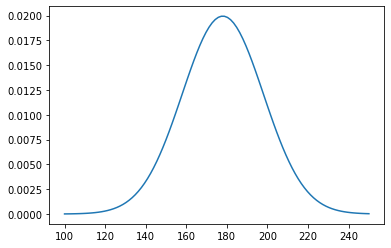

In [7]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

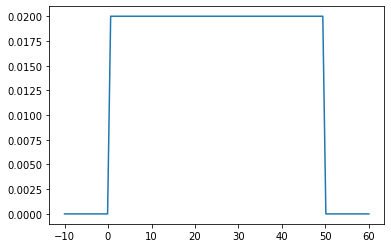

In [8]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

As a sanity check, let's sample from prior to see how is going to be the outcomes distribution

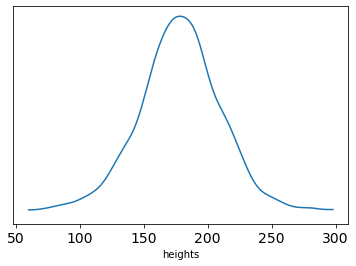

In [10]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

In [22]:
az.summary(prior_h, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,178.03,34.37,114.59,249.42


#### Calculation Posterior: 

In [13]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(data.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

Here is the posterior of the parameters. It is a joint distribution of $sigma$ and $mu$. 

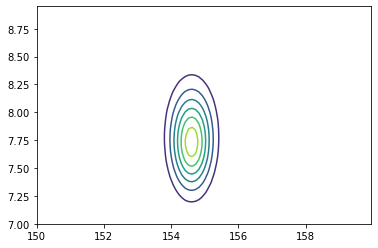

In [14]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

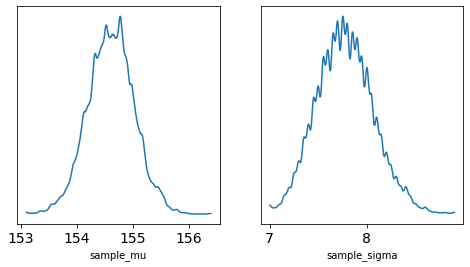

In [18]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

##### Sampling from posterior: 

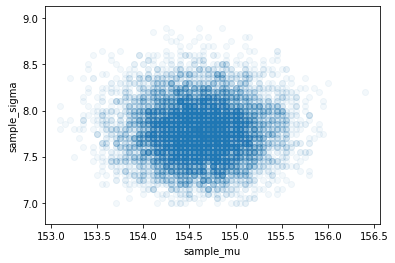

In [17]:
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

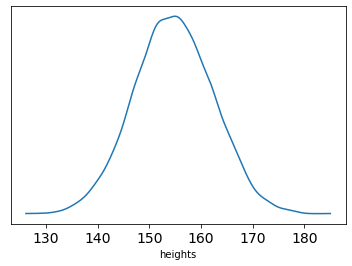

In [20]:
n_samples = 1000
post_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(post_h)
plt.xlabel("heights")
plt.yticks([]);


In [21]:
az.summary(post_h, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,154.63,7.68,140.19,168.91


### Conclusion:
Notice how close to the initial distribution it is. 
we Learn a distribution based on data and a prior distribution. 